<a href="https://colab.research.google.com/github/basel5621/Vegetable-Image-Classification/blob/main/Pytorch_vegetables_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'vegetable-image-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1817999%2F2965251%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240928%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240928T093945Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D30c45495fae5ea886f341951b42d93484c43cd9899d229691d4d693eb2eeb561b2257cd6f3d767be118b2fb88abd74882fadcf92943be2804d4acc4ebb47eb612b88f4b2a2f71f33167c7e6dd34c03510dd1e16f0b2882303596e8da7eb2b449ec665e107cd7a0a07ed10d56f2854bf029a1d7ca790ea913b7cbef57e8bd8738f21496aac2074571139204e61abedfe8c51e277411852a20daf354d2a5ef0521b4350cc7861db46fcaa7a8a67ef7ad07a7f6f53b1c39c12421d5be866cc92e661a85751f6e04954e315bf2f2611f2db999d14cd6f30f4f569d5485c4639da60ab88a202181b0af70c02e14878117f4f257d8b1f4ddc16d8fa3ee22e66d843689'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 560031432 bytes downloaded
Downloaded and uncompressed: vegetable-image-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

print('DONE')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

DONE


In [3]:
import torchvision
from torchvision import transforms

train_dataset_path='/kaggle/input/vegetable-image-dataset/Vegetable Images/train'
transforms = transforms.Compose([transforms.Resize((64,64)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485,0.456,0.406],
                                                       std=[0.229,0.224,0.225])
                                  ])
train_data = torchvision.datasets.ImageFolder(train_dataset_path,transform=transforms)

In [4]:
train_data

Dataset ImageFolder
    Number of datapoints: 15000
    Root location: /kaggle/input/vegetable-image-dataset/Vegetable Images/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
validation_dataset_path='/kaggle/input/vegetable-image-dataset/Vegetable Images/validation'
val_data=torchvision.datasets.ImageFolder(validation_dataset_path,transform=transforms)

test_dataset_path='/kaggle/input/vegetable-image-dataset/Vegetable Images/test'
test_data=torchvision.datasets.ImageFolder(test_dataset_path,transform=transforms)

In [6]:
from torch.utils import data
batch_size=64
train_data_loader = data.DataLoader(train_data, batch_size, shuffle=True)
val_data_loader = data.DataLoader(val_data, batch_size, shuffle=True)
test_data_loader = data.DataLoader(test_data, batch_size, shuffle=True)

In [7]:
train_data_loader

In [50]:
labels=train_data_loader.dataset.classes
labels={i:labels[i] for i in range(len(labels))}
labels

{0: 'Bean',
 1: 'Bitter_Gourd',
 2: 'Bottle_Gourd',
 3: 'Brinjal',
 4: 'Broccoli',
 5: 'Cabbage',
 6: 'Capsicum',
 7: 'Carrot',
 8: 'Cauliflower',
 9: 'Cucumber',
 10: 'Papaya',
 11: 'Potato',
 12: 'Pumpkin',
 13: 'Radish',
 14: 'Tomato'}

In [17]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
class CNNNet(nn.Module):
  def __init__(self , img_width, img_height, num_classes=15):
    super(CNNNet,self).__init__()
    self.features=nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(32,64,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(64,128,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(128,256,kernel_size=3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),

    )
    self.flatten = nn.Flatten()
    input_size = (img_width // 16) * (img_height // 16) * 256
    self.classifier = nn.Sequential(
        nn.Linear(input_size,1024),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1024,num_classes)
    )

  def forward(self,x):
    x = self.features(x)
    x = self.flatten(x)
    x = self.classifier(x)
    return x


In [24]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
num_classes = 15

model = CNNNet(img_width=IMG_WIDTH, img_height=IMG_HEIGHT, num_classes=num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [25]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Using GPU')
else:
    device = torch.device("cpu")
    print('Using CPU')
model.to(device)

Using GPU


CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1024, out_features=15, bias=True)
  

In [26]:
import pandas as pd
def train_model(model , optimizer , loss_fn ,train_loader ,val_loader, epochs=20,device='cpu'):
  train_loss_history=[]
  val_loss_history=[]
  for epoch in range(epochs):
    training_loss=0
    valid_loss=0
    model.train()
    for batch in train_loader:
      optimizer.zero_grad()
      inputs,targets = batch
      inputs = inputs.to(device)
      targets = targets.to(device)
      output=model(inputs)
      loss= loss_fn(output,targets)
      loss.backward()
      optimizer.step()
      training_loss+= loss.data.item() * inputs.size(0)
    training_loss/= len(train_loader.dataset)

    model.eval()
    num_correct = 0
    num_examples = 0
    for batch in val_loader:
      inputs,targets=batch
      inputs = inputs.to(device)
      targets = targets.to(device)
      output=model(inputs)
      loss= loss_fn(output,targets)
      valid_loss += loss.data.item() * inputs.size(0)
      correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
      num_correct += torch.sum(correct).item()
      num_examples += correct.shape[0]
    valid_loss /= len(val_loader.dataset)
    print('Epoch: {}, Training Loss: {}, Validation Loss: {}, accuracy = {}'.format(epoch+1, training_loss,valid_loss, num_correct / num_examples))
    train_loss_history.append(training_loss)
    val_loss_history.append(valid_loss)
  df= pd.DataFrame({'train_loss':train_loss_history,'valid_loss':val_loss_history})
  return df

In [27]:
history = train_model(model,optimizer,criterion,train_data_loader,val_data_loader,epochs=50,device=device)

Epoch: 1, Training Loss: 1.1788515106201172, Validation Loss: 0.4705664472579956, accuracy = 0.852
Epoch: 2, Training Loss: 0.3337478947162628, Validation Loss: 0.28514869141578675, accuracy = 0.9163333333333333
Epoch: 3, Training Loss: 0.1578528274854024, Validation Loss: 0.1791295260488987, accuracy = 0.95
Epoch: 4, Training Loss: 0.11086022547483444, Validation Loss: 0.14683803563316664, accuracy = 0.957
Epoch: 5, Training Loss: 0.0678115102507174, Validation Loss: 0.10297406653563182, accuracy = 0.9736666666666667
Epoch: 6, Training Loss: 0.04665349453836679, Validation Loss: 0.11351153535147508, accuracy = 0.9746666666666667
Epoch: 7, Training Loss: 0.04491339748402436, Validation Loss: 0.17267677728335062, accuracy = 0.9613333333333334
Epoch: 8, Training Loss: 0.04688457982192437, Validation Loss: 0.12951612173269192, accuracy = 0.9713333333333334
Epoch: 9, Training Loss: 0.038276776899925126, Validation Loss: 0.10208379787237694, accuracy = 0.9766666666666667
Epoch: 10, Training

<Axes: >

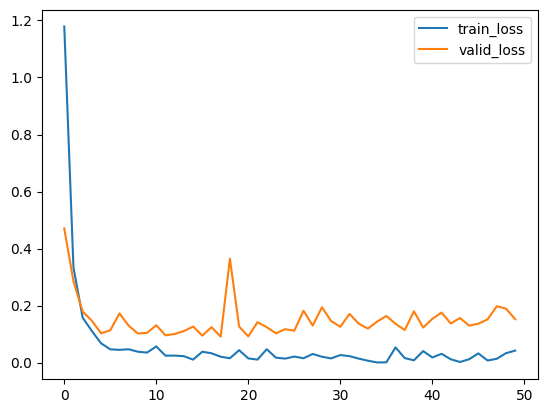

In [28]:
history[['train_loss','valid_loss']].plot()

In [29]:
def test_model(model, test_loader, device):
    # Set model to evaluation mode
    model.eval()

    # Variables to track performance
    total_correct = 0
    total_samples = 0
    loss_sum = 0.0

    # Disable gradient calculations (faster and saves memory)
    with torch.no_grad():
        for data, labels in test_loader:
            # Move data to the appropriate device
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)

            # Calculate the loss (assuming CrossEntropyLoss)
            loss = F.cross_entropy(outputs, labels)
            loss_sum += loss.item()

            # Get predictions from the output
            _, predicted = torch.max(outputs, 1)

            # Compare predictions to actual labels
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate average loss and accuracy
    avg_loss = loss_sum / len(test_loader)
    accuracy = total_correct / total_samples * 100

    print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

    return avg_loss, accuracy

In [31]:
test_loss , test_accuracy = test_model(model, test_data_loader, device)

Test Loss: 0.1491, Test Accuracy: 97.23%


In [59]:
import numpy as np

def predict(model, test_generator, labels, device):
    model.eval()

    y_true = []
    y_pred = []

    for inputs, targets in test_generator:
        inputs = inputs.to(device)
        targets = targets.numpy()

        probabilities, predicted_classes = _predict(model, inputs, device)

        y_true.extend(targets)
        y_pred.extend(predicted_classes.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    return y_true,y_pred


def _predict(model, input_data, device):
    model.eval()

    if isinstance(input_data, np.ndarray):
        input_data = torch.tensor(input_data).float().to(device)

    if input_data.ndim == 3:
        input_data = input_data.unsqueeze(0)

    with torch.no_grad():
        outputs = model(input_data)

        probabilities = torch.softmax(outputs, dim=1)

        _, predicted_classes = torch.max(probabilities, 1)

    return probabilities, predicted_classes


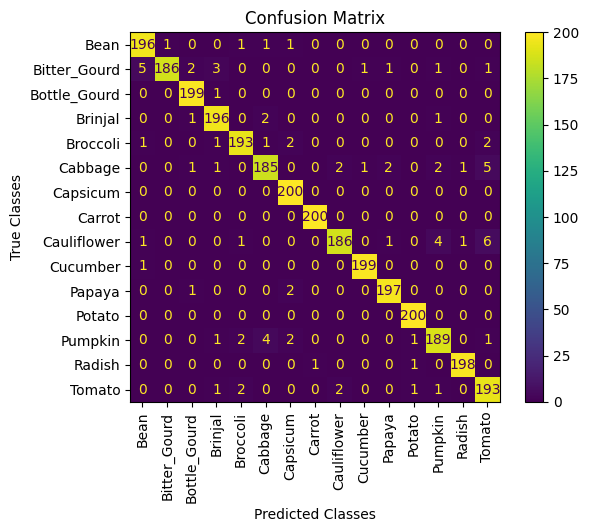

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

y_true, y_pred=predict(model, test_data_loader, labels, device)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())
disp.plot()
plt.xticks(rotation=90)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

In [61]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

        Bean       0.96      0.98      0.97       200
Bitter_Gourd       0.99      0.93      0.96       200
Bottle_Gourd       0.98      0.99      0.99       200
     Brinjal       0.96      0.98      0.97       200
    Broccoli       0.97      0.96      0.97       200
     Cabbage       0.96      0.93      0.94       200
    Capsicum       0.97      1.00      0.98       200
      Carrot       1.00      1.00      1.00       200
 Cauliflower       0.98      0.93      0.95       200
    Cucumber       0.99      0.99      0.99       200
      Papaya       0.98      0.98      0.98       200
      Potato       0.99      1.00      0.99       200
     Pumpkin       0.95      0.94      0.95       200
      Radish       0.99      0.99      0.99       200
      Tomato       0.93      0.96      0.95       200

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97   